In [1]:
# prompt: link with google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/STM")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler ,  StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pickle

In [4]:
df_feat = pd.read_csv('/content/drive/MyDrive/STM/encoded data/opamps-features.csv')
df_ref = pd.read_csv('/content/drive/MyDrive/STM/encoded data/opamps-xref.csv')

# Prétraitement

In [5]:
categorical_columns = ["Supplier_Package","MANUFACTURER"]
numerical_columns = ["Maximum Input Offset Voltage","Maximum Single Supply Voltage","Minimum Single Supply Voltage","Number of Channels per Chip","Typical Gain Bandwidth Product"]

## Normalisation des données numériques

In [6]:
import helper_functions.preprocess as pp

df_feat_scaled , scaler = pp.scale(df_feat,numerical_columns)
df = pp.merge_datasets(df_feat_scaled,df_ref)

## Conversion de la Cross Reference Type en numerique

In [7]:
base_means = {'A': 0.95, 'B': 0.8, 'C': 0.65, 'D': 0.5}
base_std = {'A': 0.025 / 3, 'B': 0.025 / 2.5, 'C': 0.025 / 2, 'D': 0.025 / 1.5}

<Axes: xlabel='Closeness', ylabel='Density'>

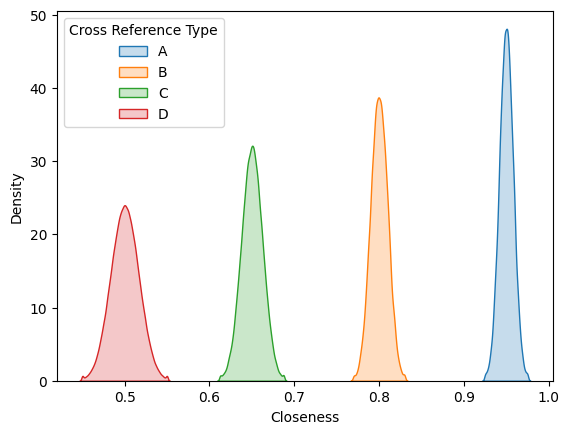

In [9]:
df = pp.generate_closeness(df,base_means,base_std,n_std=3)
sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

## Division de la Dataset

In [10]:
df_train, df_validation, df_test = pp.split_dataframe(df)

In [11]:
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_validation)}")
print(f"Test size: {len(df_test)}")

Train size: 818553
Validation size: 51159
Test size: 153480


## Resolution du probleme d'equilibre des classes

Cela doit être fait sur seuleument la base d'entrainnement, sinon ça peut pas refletter la performance relle des modeles

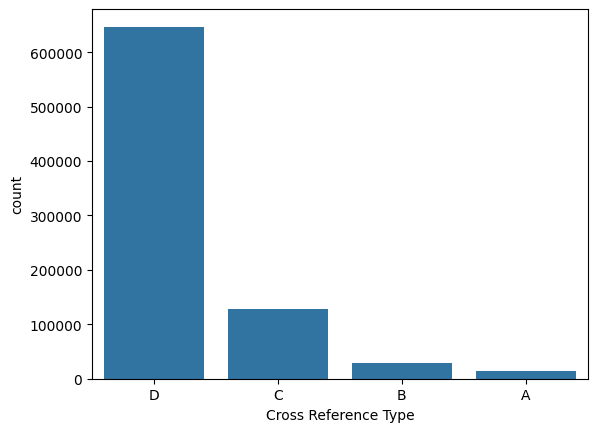

In [12]:
sns.countplot(df_train, x="Cross Reference Type")
plt.show()

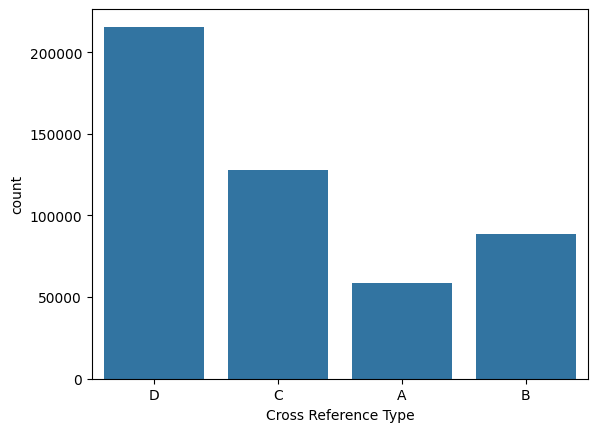

In [11]:
df_train = pp.balance_training_data(df_train,ratios={"A": 4, "B": 3, "C": 1, "D": 1/3})
sns.countplot(df_train, x="Cross Reference Type")
plt.show()

In [14]:
df_train.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'Mean', 'Std', 'Closeness'],
      dtype='object')

# ML models

In [12]:
X_train, X_test = df_train.drop(columns=['Closeness', 'MPN', 'MPN_comp', 'Mean', 'Std',"Cross Reference Type"]),df_test.drop(columns=['Closeness', 'MPN', 'MPN_comp', 'Mean', 'Std',"Cross Reference Type"])
y_train, y_test = df_train['Closeness'] , df_test['Closeness']

In [13]:
categorical_columns+=[i +"_comp" for i in categorical_columns]

In [14]:
categorical_columns

['Supplier_Package',
 'MANUFACTURER',
 'Supplier_Package_comp',
 'MANUFACTURER_comp']

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),

    ],
    remainder='passthrough'
)

In [16]:
results = {}

## Linear Regression

In [53]:
from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

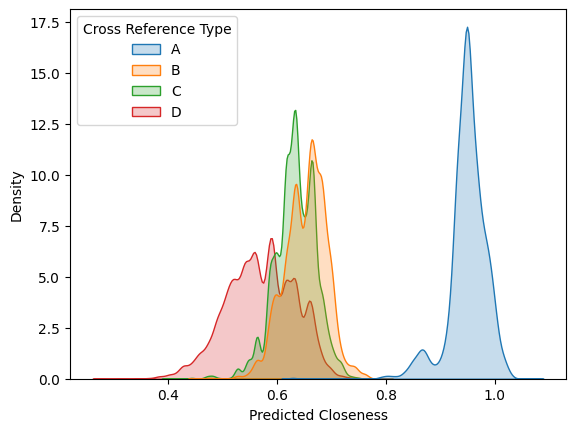

In [54]:
pipeline.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [60]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline)

Building closeness matrix: 100%|██████████| 18352/18352 [13:48<00:00, 22.16it/s]


'closeness_matrix.npy'

In [7]:
data = np.load("closeness_matrix.npy", mmap_mode='r')

<Axes: ylabel='Count'>

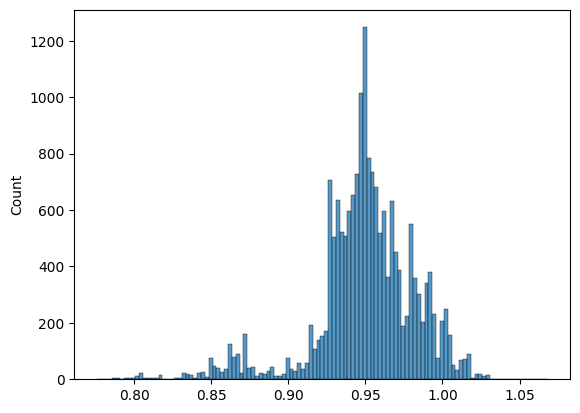

In [13]:
data = np.load("closeness_matrix.npy", mmap_mode='r')
sns.histplot(data.diagonal()) #repartition des score de similarité d'un produit avec lui même (doit être proche de 0.9)

## Decision Tree

In [30]:
from sklearn.tree import DecisionTreeRegressor
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ])

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

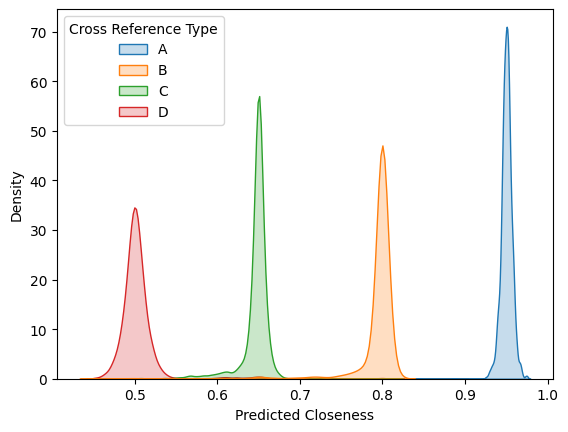

In [31]:
pipeline.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline.predict(X_test)
results["Decision Tree"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [32]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Decision Tree.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [14:32<00:00, 21.04it/s]


'closeness_matrix Decision Tree.npy'

<Axes: ylabel='Count'>

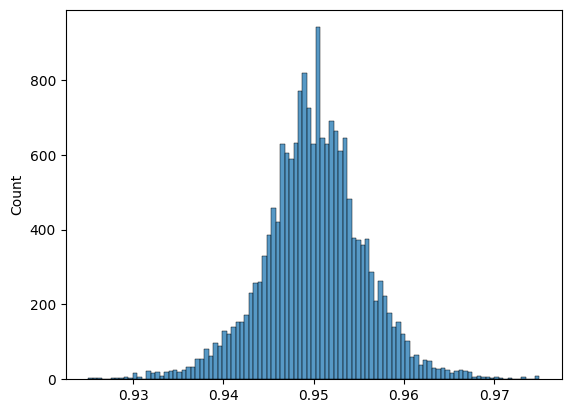

In [33]:
data = np.load("closeness_matrix Decision Tree.npy", mmap_mode='r')
sns.histplot(data.diagonal()) #repartition des score de similarité d'un produit avec lui même (doit être proche de 0.9)

## Random Forest

In [5]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

ImportError: libcublas.so.11: cannot open shared object file: No such file or directory

In [72]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


LightGBMError: CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1

In [ ]:
# Predict and store results
y_pred = pipeline.predict(X_test)
results["Random forest"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

## Kneighborsregressor

In [18]:
from sklearn.neighbors import KNeighborsRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=30))
])

In [19]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Supplier_Package',
                                                   'MANUFACTURER',
                                                   'Supplier_Package_comp',
                                                   'MANUFACTURER_comp'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=30))])

In [ ]:
# Predict and store results
y_pred = pipeline.predict(X_test)
results["KNeighborsRegressor"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
import helper_functions.test as tt
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Decision Tree.npy")